In [1]:
pip install 'monai[all]'

     |████████████████████████████████| 584 kB 8.4 MB/s 
     |████████████████████████████████| 2.9 MB 33.5 MB/s 
     |████████████████████████████████| 221 kB 50.5 MB/s 
     |████████████████████████████████| 316 kB 47.2 MB/s 
     |████████████████████████████████| 76 kB 4.1 MB/s 
     |████████████████████████████████| 36.3 MB 60 kB/s 
     |████████████████████████████████| 68.0 MB 83 kB/s 
     |████████████████████████████████| 50.1 MB 80 kB/s 
     |████████████████████████████████| 14.0 MB 416 kB/s 
     |████████████████████████████████| 10.3 MB 19.9 MB/s 
     |████████████████████████████████| 14.4 MB 26.6 MB/s 
  Created wheel for openslide-python: filename=openslide_python-1.1.2-cp37-cp37m-linux_x86_64.whl size=27705 sha256=3bc15fef20a7f714214889e5b1686f65b6d7f832cb840c1ab3de6410f86dc0d7
  Stored in directory: /root/.cache/pip/wheels/6f/c3/97/980962653f9305314bfb6d93f80be5e21f13e206af66fc7ad3
Successfully built openslide-python
  Attempting uninstall: tqdm
    Found exi

In [2]:
import monai
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import torchvision
import logging
import numpy as np
import pickle
import os
import sys
import joblib
import json
import tempfile
import matplotlib.pyplot as plt

from scipy.special import softmax
from torch.nn import Module
from torch import sigmoid
from sklearn.model_selection import KFold
from sklearn import preprocessing
from monai.data import CacheDataset, DataLoader, Dataset, list_data_collate, ImageDataset, ITKReader, ArrayDataset
from monai.transforms import LoadImageD, EnsureChannelFirstD, AddChannelD, ScaleIntensityD, ToTensorD, Compose, AsDiscreteD, SpacingD, OrientationD, ResizeD, RandAffineD, Activations, Resize
from monai.networks.layers import Norm
from monai.networks.nets import UNet, BasicUNet, VNet
from monai.losses import DiceLoss
from monai.engines import SupervisedTrainer, Trainer, SupervisedEvaluator
from torch.utils.data import DataLoader
from monai.inferers import sliding_window_inference
from monai.handlers import StatsHandler, MeanDice
from monai.transforms.utils import allow_missing_keys_mode
from keras.models import model_from_json, Model
from monai.metrics import DiceMetric
from monai.utils import set_determinism, first
from monai.metrics import compute_meandice
from torch.utils.tensorboard import SummaryWriter
from monai.visualize import plot_2d_or_3d_image
from torch.autograd import Variable
from monai.networks import one_hot

from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    Activations,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
    ScaleIntensityd,
    RandRotate90d,
    MeanEnsemble
)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=3599bce26914a0f58408316c395b62fdc67287aaf76b4c2efe09089ac1ca94e8
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [5]:
cd gdrive/MyDrive/Echocardiography_ML_Project_Summer_2021/ 

/content/gdrive/MyDrive/Echocardiography_ML_Project_Summer_2021


In [6]:
import import_ipynb
from KFoldFunction import kFoldSplit

importing Jupyter notebook from KFoldFunction.ipynb


In [7]:
img_list = []

In [8]:
folder_list = []

In [9]:
directory_main = "/content/gdrive/My Drive/Echocardiography_ML_Project_Summer_2021"

In [10]:
directory = "/content/gdrive/My Drive/CAMUS/training"

seg_count = 0
img_count = 0

for folder in os.listdir(directory):
  file_path = directory + '/' + folder
  
  folder_list.append(file_path)
  
  #for file in os.listdir(file_path):

    #if ".mhd" in file and "gt" not in file and "2CH" not in file and "sequence" not in file:
      #file_img = file_path + '/' + file
      #file_path + '/' + file
      
      #print(file_img)
      #img_list.append(file_img)

      #file_img = ''
      #img_count += 1

In [13]:
fold = kFoldSplit(folder_list,2)
print(len(fold['test']),len(fold['train']),len(fold['validation']))

45 360 45


In [14]:
train_set_patients = fold['train']
val_set_patients = fold['validation']

In [15]:
train_set = []
val_set = []

In [16]:
for patient in train_set_patients:
  for file in os.listdir(patient):
    file_str = file.decode("utf-8")

    if ".mhd" in file_str and "gt" not in file_str and "2CH" not in file_str and "sequence" not in file_str:
      file_img = patient + '/' + file_str
    #file_path + '/' + file
    
      #print(file_img)
      train_set.append(file_img)

    #file_img = ''
    #img_count += 1

In [17]:
for patient in val_set_patients:
  for file in os.listdir(patient):
    file_str = file.decode("utf-8")

    if ".mhd" in file_str and "gt" not in file_str and "2CH" not in file_str and "sequence" not in file_str:
      file_img = patient + '/' + file_str
    #file_path + '/' + file
    
      #print(file_img)
      val_set.append(file_img)

    #file_img = ''
    #img_count += 1

In [18]:
train_seg_list = [""]*len(train_set)

for i in range(len(train_set)):
  str = (train_set[i])[0:len(train_set[i])-4] + "_gt.mhd"
  train_seg_list[i] = str

val_seg_list = [""]*len(val_set)

for i in range(len(val_set)):
  str = (val_set[i])[0:len(val_set[i])-4] + "_gt.mhd"
  val_seg_list[i] = str

In [19]:
train_list_data = [{}]*len(train_set)

for i in range(len(train_set)):
  img_label_dict = {'image':train_set[i],'label':train_seg_list[i]}
  
  train_list_data[i] = img_label_dict

In [20]:
val_list_data = [{}]*len(val_set)

for i in range(len(val_set)):
  img_label_dict = {'image':val_set[i],'label':val_seg_list[i]}
  
  val_list_data[i] = img_label_dict

In [ ]:
train_list_data_truncated = [{}]*30
val_list_data_truncated = [{}]*30

for i in range(0,30):
  train_list_data_truncated[i] = (train_list_data[i])
  val_list_data_truncated[i] = (val_list_data[i])

In [21]:
keys = ['image','label']

transforms = Compose(
    [
     LoadImageD(keys),
     ResizeD(keys,[256,256]),
     ToTensorD(keys)
    ]
)
#try larger batch size
batch_size = 16
num_workers = 4

In [22]:
ds = Dataset(train_list_data,transforms)
train_loader = DataLoader(ds,batch_size,num_workers)

val_ds = Dataset(val_list_data,transforms)
val_loader = DataLoader(val_ds,batch_size,num_workers)

In [23]:
device = torch.device('cuda:0')
model = monai.networks.nets.UNet(
    dimensions=2,
    in_channels=1,  
    out_channels=4,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,

).to(device)
loss_function = DiceLoss(to_onehot_y=True,softmax=True)#, squared_pred=True)
optimizer = torch.optim.Adam(
    model.parameters(), 1e-3#, weight_decay=1e-5, amsgrad=True
)

In [ ]:
print('Trainable params: {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Trainable params: 6496585


In [25]:
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()
post_label = AsDiscrete(to_onehot=True, n_classes=2)
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)

for epoch in range(45):
  print("-" * 45)
  print(f"epoch {epoch + 1}/{45}")
  model.train()
  epoch_loss = 0
  step = 0
  for batch_data in train_loader:
      step += 1
      inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
    
      optimizer.zero_grad()
      
      outputs = model(inputs)
      #outputs = torch.nn.Sigmoid()(outputs)

      loss = loss_function(outputs, labels)
      loss.backward()

      optimizer.step()
      epoch_loss += loss.item()
      epoch_len = len(ds) // train_loader.batch_size
      print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
      writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)
  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

  if (epoch + 1) % val_interval == 0:
      model.eval()
      with torch.no_grad():
          metric_sum = 0.0
          metric_count = 0

          val_images = None
          val_labels = None
          val_outputs = None

          for val_data in val_loader:

              #print(val_data["image"])
              val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
              
              val_outputs = model(val_images)
              #print("after model",val_outputs.shape,val_outputs)

              val_outputs = torch.nn.Softmax(dim=1)(val_outputs)
              #print("after softmax",val_outputs.shape,val_outputs)

              val_outputs = torch.argmax(val_outputs,dim=1,keepdim=True)
              #print("after argmax",val_outputs.shape,val_outputs)

              #val_outputs = post_trans(val_outputs)
              val_outputs = one_hot(val_outputs,num_classes=4,dim=1)
              #print("after one hot",val_outputs.shape,val_outputs)

              #val_labels = post_trans_label(val_labels)
              val_labels = one_hot(val_labels,num_classes=4,dim=1)

              value = compute_meandice(
                y_pred=val_outputs,
                y=val_labels,
                include_background=True,
              )

              #print("value",value.shape,value)
              
              metric_count += len(value)
              metric_sum += value[:,1,...].sum() 
          metric = metric_sum / metric_count
          metric_values.append(metric)
          if metric > best_metric:
              best_metric = metric
              best_metric_epoch = epoch + 1
              #torch.save(model.state_dict(), root_dir)
              model_name = 'best_segmentation_model_fold_3.pth'
              path = os.path.join(directory_main,model_name)
              torch.save(model.state_dict(),path)

              print("saved new best metric model")
          print(
              "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                  epoch + 1, metric, best_metric, best_metric_epoch
              )
          )

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

---------------------------------------------
epoch 1/45
1/45, train_loss: 0.7787
2/45, train_loss: 0.7691
3/45, train_loss: 0.7728
4/45, train_loss: 0.7662
5/45, train_loss: 0.7545
6/45, train_loss: 0.7590
7/45, train_loss: 0.7496
8/45, train_loss: 0.7428
9/45, train_loss: 0.7580
10/45, train_loss: 0.7489
11/45, train_loss: 0.7495
12/45, train_loss: 0.7482
13/45, train_loss: 0.7518
14/45, train_loss: 0.7365
15/45, train_loss: 0.7341
16/45, train_loss: 0.7472
17/45, train_loss: 0.7240
18/45, train_loss: 0.7322
19/45, train_loss: 0.7313
20/45, train_loss: 0.7181
21/45, train_loss: 0.7227
22/45, train_loss: 0.7156
23/45, train_loss: 0.7151
24/45, train_loss: 0.7220
25/45, train_loss: 0.7205
26/45, train_loss: 0.7166
27/45, train_loss: 0.7241
28/45, train_loss: 0.7144
29/45, train_loss: 0.7202
30/45, train_loss: 0.7028
31/45, train_loss: 0.7050
32/45, train_loss: 0.7064
33/45, train_loss: 0.7040
34/45, train_loss: 0.7069
35/45, train_loss: 0.7040
36/45, train_loss: 0.6990
37/45, train_los

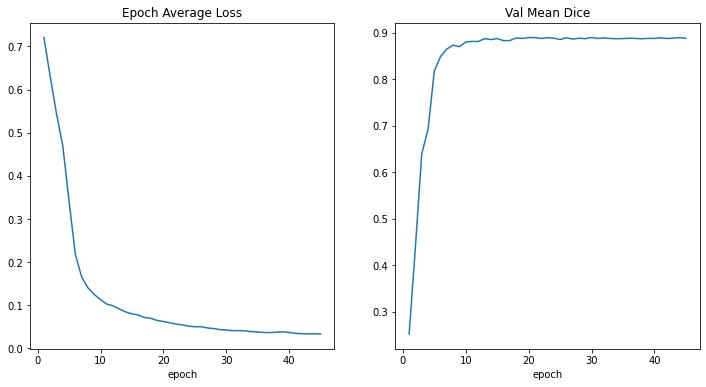

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()